In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
from copy import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import fnmatch
import csv
import pickle
import warnings
import scipy
from scipy import optimize
from scipy.optimize import leastsq
from io import StringIO
from scipy.signal import savgol_filter
from datetime import datetime
from matplotlib import cm
#from colorspacious import cspace_converter
from collections import OrderedDict


now = datetime.now()
d_string = now.strftime("%d.%m.%Y")

%run Functions.ipynb



<Figure size 432x288 with 0 Axes>

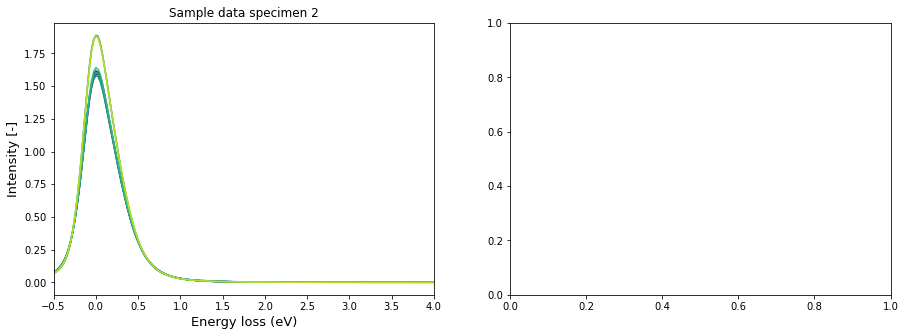

In [2]:
%run EELS-ZLP-Sabrya.py

In [3]:
cols=['y14', 'x14', 'y15', 'x15', 'y16', 'x16', 'y17', 'x17', 'y19', 'x19', 'y20', 'x20', 'y21', 'x21', 'y22', 'x22', 'y23', 'x23']

ZLP_data = pd.concat((file14, file15, file16, file17, file19, file20, file21, file22, file23), axis=1)
ZLP_data = ZLP_data.drop(['x', 'y_norm'],axis=1).rename(columns={'x_shifted': 'x'})
ZLP_data.columns = cols
ZLP_data

,y14,x14,y15,x15,y16,x16,y17,x17,y19,x19,y20,x20,y21,x21,y22,x22,y23,x23
0,636.127,-4.000,538.323,-4.000,343.679,-4.000,492.3560,-4.000,507.876,-4.000,653.647,-4.000,468.812,-4.000,363.02700,-4.000,257.97500,-4.000
1,498.927,-3.975,616.320,-3.975,438.293,-3.975,480.3930,-3.975,531.430,-3.975,449.859,-3.975,540.792,-3.975,280.05000,-3.975,399.72700,-3.975
2,498.176,-3.950,509.958,-3.950,377.857,-3.950,369.5180,-3.950,504.945,-3.950,453.914,-3.950,520.245,-3.950,339.00500,-3.950,405.57600,-3.950
3,577.528,-3.925,473.872,-3.925,453.746,-3.925,606.7700,-3.925,533.959,-3.925,482.429,-3.925,408.308,-3.925,293.62600,-3.925,393.66800,-3.925
4,569.234,-3.900,483.648,-3.900,532.302,-3.900,457.2570,-3.900,668.418,-3.900,594.406,-3.900,393.705,-3.900,368.57000,-3.900,405.67700,-3.900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1976,1275.390,45.400,1410.760,45.400,1210.870,45.400,40.4888,45.400,1330.200,45.400,895.710,45.400,959.088,45.400,59.40050,45.400,106.58200,45.400
1977,1333.680,45.425,1461.460,45.425,1355.890,45.425,153.4880,45.425,1258.700,45.425,867.032,45.425,977.535,45.425,-17.28790,45.425,-19.90300,45.425
1978,1300.010,45.450,1534.430,45.450,1449.470,45.450,73.2248,45.450,1308.960,45.450,895.917,45.450,1022.390,45.450,40.96820,45.450,-9.27237,45.450
1979,975.411,45.475,1362.230,45.475,1411.280,45.475,47.3263,45.475,1333.010,45.475,968.698,45.475,1150.030,45.475,-40.43750,45.475,80.59390,45.475


## Load predictions and training data

- Load the data files of today
- Select the ones that are good, based on a minimum $\chi^2_{test}$
- Only keep the good ones to make predictions


In [51]:
d_string = '18.08.2020'

path_1 = r'Data/Results/Sabrya/%(now)s/' % {"now": d_string} # use your path
round_no = 'x9'
path_data = r'*_xyp1p2_*.csv'
path_chi = r'*_chi_*.csv' 
path_pred = path_4 = r'*_extrapolation_*'

all_files = glob.glob(path_1 + round_no + path_data)
li = []
for filename in all_files:
    df = pd.read_csv(filename, delimiter=",",  header=0, usecols=[0,1,2], names=['x', 'y', 'pred'])
    li.append(df)
frame = pd.concat(li, axis=0, ignore_index=True)


In [52]:
# Put all data in a dataframe

training_data = pd.DataFrame()
training_data['x'] = frame.iloc[:,0]
training_data['y'] = frame.iloc[:,1]
training_data['prediction'] = frame.iloc[:,2]

training_data.describe()

,x,y,prediction
count,20400.000000,20400.000000,20400.000000
mean,5.169794,6.263514,6.340596
std,4.790792,5.641039,5.038169
min,-0.500000,0.177133,0.339883
25%,0.658088,0.507043,0.520045
50%,2.047794,8.274817,6.551518
75%,10.344828,11.796394,10.663109
max,12.000000,14.750668,14.863008


In [53]:
all_files_chi = glob.glob(path_1 + round_no + path_chi)

In [54]:
all_files_chi_sort = np.sort(all_files_chi)
chi2_array = []
chi2_index = []

for filename in all_files_chi_sort:
    df = pd.read_csv(filename, delimiter=",", header=0, usecols=[0,1], names=['train', 'test'])
    best_try = np.argmin(df['test'])
    chi2_array.append(df.iloc[best_try,0])
    chi2_index.append(best_try)

chi_data  = pd.DataFrame()
chi_data['Best chi2 value'] = chi2_array
chi_data['Epoch'] = chi2_index
    
print("total length of files:", len(chi2_array))

total length of files: 400


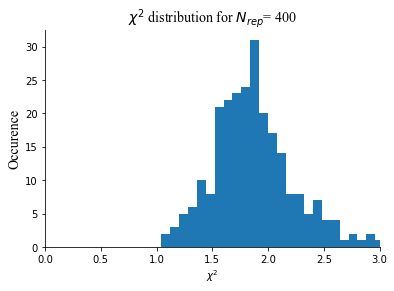

In [55]:
plt.hist(chi_data['Best chi2 value'], density=False, bins=50, range=[0, 4])
csfont = {'fontname':'Comic Sans MS'}
hfont = {'fontname':'Times New Roman'}

plt.title('title',**csfont)
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.xlabel('xlabel', **hfont)
plt.title('$\chi^2$ distribution for $N_{rep}$= %(s)s ' % {"s": len(chi2_array)}, fontsize=14, **hfont)
plt.xlabel('$\chi^2$')
plt.xlim([0, 3])
plt.ylabel('Occurence', fontsize=14, **hfont)
plt.savefig('Data/Results/histogram.png')
plt.show()



## Post-selection criteria

In [56]:
good_files = []
count = 0
selection_min = 3
for i,j in enumerate(chi2_array):
    if j < selection_min:
        good_files.append('Keep') 
        count +=1 
    else:
        good_files.append('Discard')

print("The number of files that survived the selection is", count)

The number of files that survived the selection is 248


## Load extrapolation data

For each replica, the prediction should be taken separately:\
     $substracted\_spectrum_k = original\_spectrum - ZLP_k$

In [57]:
all_files_ex = glob.glob(path_1 + round_no + path_pred)
all_files_ex_sort = np.sort(all_files_ex)
use_files = []

for i,j in enumerate(good_files):
    if j == 'Keep':
        file = all_files_ex_sort[i]
        use_files.append(file)

original = pd.DataFrame()
## Use original ZLP data to subtract:
original = ZLP_data[(ZLP_data['x14'] >= -.3) & (ZLP_data['x14'] <= 12)]


        
original

,y14,x14,y15,x15,y16,x16,y17,x17,y19,x19,y20,x20,y21,x21,y22,x22,y23,x23
148,456807.00,-0.300,443699.00,-0.300,450995.00,-0.300,5.034260e+05,-0.300,442660.00,-0.300,441120.00,-0.300,459881.00,-0.300,5.174190e+05,-0.300,5.037820e+05,-0.300
149,566029.00,-0.275,551607.00,-0.275,560576.00,-0.275,6.422090e+05,-0.275,545933.00,-0.275,550061.00,-0.275,574477.00,-0.275,6.592920e+05,-0.275,6.406290e+05,-0.275
150,700720.00,-0.250,682530.00,-0.250,688731.00,-0.250,8.178620e+05,-0.250,669937.00,-0.250,682450.00,-0.250,710466.00,-0.250,8.340800e+05,-0.250,8.168200e+05,-0.250
151,859362.00,-0.225,836906.00,-0.225,841517.00,-0.225,1.032170e+06,-0.225,819685.00,-0.225,836363.00,-0.225,870625.00,-0.225,1.040390e+06,-0.225,1.030730e+06,-0.225
152,1043450.00,-0.200,1011460.00,-0.200,1020170.00,-0.200,1.280630e+06,-0.200,988357.00,-0.200,1010900.00,-0.200,1057100.00,-0.200,1.281640e+06,-0.200,1.282600e+06,-0.200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,3004.28,11.900,3340.29,11.900,3246.22,11.900,7.397430e+01,11.900,3509.83,11.900,3176.18,11.900,3038.65,11.900,2.092110e+02,11.900,1.225980e+01,11.900
637,3081.16,11.925,3289.57,11.925,3476.48,11.925,8.971260e+01,11.925,3361.68,11.925,3274.89,11.925,3192.14,11.925,6.893910e+01,11.925,-3.215560e+01,11.925
638,3180.21,11.950,3261.40,11.950,3571.08,11.950,1.223080e+02,11.950,3121.31,11.950,3392.31,11.950,3350.05,11.950,5.079620e+01,11.950,6.970750e+01,11.950
639,3228.45,11.975,3102.58,11.975,3355.15,11.975,1.066450e+02,11.975,3144.15,11.975,3408.80,11.975,3026.45,11.975,2.019940e+02,11.975,1.103880e+01,11.975


## Matching of ZLP and data region

In [58]:
dE1 = max(training_data['x'][(training_data['x']< 3)])+ .025
dE2 = min(training_data['x'][(training_data['x']> 3)])

print('dE2 =', dE2)
dE1 = np.round(dE1, 2)
dE0 = np.round(dE1 - .5, 2) 
print('dE1 =',dE1)
print('dE0 =',dE0)

dE2 = 8.0
dE1 = 2.15
dE0 = 1.65


In [59]:
delta_divider = 3

def matching(x, y_NN, y_ZLP):
    total = pd.DataFrame({"x": x, "prediction y": y_NN, "data ZLP": y_ZLP})
    
    delta = np.divide((dE1 - dE0), delta_divider)
    
    factor_NN = np.exp(- np.divide((x[(x<dE1) & (x >= dE0)] - dE1)**2, delta**2))
    factor_ZLP = 1 - factor_NN
    
    range_0 = total[total['x'] < dE0]['data ZLP'] * 1
    range_1 = total[(total['x'] < dE1) & (total['x'] >= dE0)]['prediction y'] * factor_NN + total[(total['x'] < dE1) & (total['x'] >= dE0)]['data ZLP'] * factor_ZLP
    range_2 = total[(total['x'] >= dE1) & (total['x'] < 3 * dE2)]['prediction y'] * 1 
    range_3 = total[(total['x'] >= 3 * dE2)]['prediction y'] * 0
    totalfile = np.concatenate((range_0, range_1, range_2, range_3), axis=0)
    
    return totalfile

## Derivation of bandgap

In [60]:
from lmfit import Model
from scipy.optimize import curve_fit

def bandgap(x, amp, BG,b):
    return amp * (x - BG)**(b)

bmodel = Model(bandgap)


In [61]:
nbins = len(original['x14'])      
li = []
diff = []
count = 0

for filename in use_files:
    df = pd.read_csv(filename, delimiter=",", header=None, usecols=[0,1], names=['x', 'prediction'])
    df['k'] = count
    li.append(df)
    count += 1
    
extrapolation = pd.concat(li, axis=0, ignore_index=True)

lo = []
BG = []

for k in range(count): 
    exp_k = extrapolation[extrapolation['k'] == k ]
    nbins = len(original['x14'])  
    mean_k, var_k, count = binned_statistics(exp_k['x'], exp_k['prediction'], nbins)[0:3]
    print(k)
    
    replica_file = pd.DataFrame({"k": k, \
                                 "x14": original['x14'], \
                                 "x15": original['x15'], \
                                 "x16": original['x16'], \
                                 "x19": original['x19'], \
                                 "x20":original['x20'], \
                                 "x21": original['x21'],\
                                 #
                               "prediction log(y1)": mean_k, \
                               "prediction y": np.exp(mean_k), \
                                 #
                               "data y14": original['y14'], \
                               "data y15": original['y15'], \
                               "data y16": original['y16'], \
                               "data y19": original['y19'], \
                               "data y20": original['y20'], \
                               "data y21": original['y21'], \
                                #
                                     "match14": matching(original['x14'], np.exp(mean_k), original['y14']), \
                                     "match15": matching(original['x15'], np.exp(mean_k), original['y15']), \
                                     "match16": matching(original['x16'], np.exp(mean_k), original['y16']), \
                                     "match19": matching(original['x19'], np.exp(mean_k), original['y19']), \
                                     "match20": matching(original['x20'], np.exp(mean_k), original['y20']), \
                                     "match21": matching(original['x21'], np.exp(mean_k), original['y21'])  })
    lo.append(replica_file)
    
    
total_replicas = pd.concat(lo, axis=0, ignore_index = True, sort=False)
total_replicas.to_csv('Data/Results/Sabrya/bandgaps/final_%(s)s' % {"s": dE1})


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247


## Create bandgap files

In [756]:
r160 = pd.read_csv('Data/Results/Sabrya/bandgaps/final_1.6')
r165 = pd.read_csv('Data/Results/Sabrya/bandgaps/final_1.65')
r170 = pd.read_csv('Data/Results/Sabrya/bandgaps/final_1.7')
r175 = pd.read_csv('Data/Results/Sabrya/bandgaps/final_1.75')
r180 = pd.read_csv('Data/Results/Sabrya/bandgaps/final_1.8')
r185 = pd.read_csv('Data/Results/Sabrya/bandgaps/final_1.85')
r190 = pd.read_csv('Data/Results/Sabrya/bandgaps/final_1.9')
r195 = pd.read_csv('Data/Results/Sabrya/bandgaps/final_1.95')
r200 = pd.read_csv('Data/Results/Sabrya/bandgaps/final_2.0')
r205 = pd.read_csv('Data/Results/Sabrya/bandgaps/final_2.05')
r210 = pd.read_csv('Data/Results/Sabrya/bandgaps/final_2.10')
r215 = pd.read_csv('Data/Results/Sabrya/bandgaps/final_2.15')
r220 = pd.read_csv('Data/Results/Sabrya/bandgaps/final_2.20')
#r225 = pd.read_csv('Data/Results/Sabrya/bandgaps/final_2.25')


In [ ]:
r_array = [r160, r165, r170, r175, r180, r185, r190, r195, r200, r205, r210, r215, r220]
dE1_array = [1.6, 1.65, 1.7, 1.75, 1.9, 1.96]

In [760]:

total_replicas = r180

nbins = len(original['x14'])
for i in ([14, 15, 16, 19, 20, 21]):
    total_replicas['dif%(i)s'%{"i": i}] = total_replicas['data y%(i)s'%{"i": i}] - total_replicas['match%(i)s'%{"i": i}]



In [761]:
nbins = len(original['x14'])      
li = []
diff = []
count = total_replicas['k'].max()

lo = []
BG = []

total_replicas = r180

for k in range(count): 
    plus = 1.2
    E_lim = dE0 + plus
    
    replica_file = total_replicas[total_replicas['k'] == k]
    print(k)
    
    for i in ([14]):
        bandgap_file = replica_file[(replica_file['x%(s)s'%{"s": i}] > 0) & (replica_file['x%(s)s'%{"s": i}]<E_lim) &\
                           (replica_file['dif%(s)s'%{"s": i} ] >= 250)]
        bandgap_file = bandgap_file.dropna()
        
        if bandgap_file['dif%(s)s'%{"s": i}].empty:
            print('empty')
            break
        
        try:
            pars, cov = curve_fit(f=bandgap, xdata=bandgap_file['x%(s)s' % {"s": i}], \
                              ydata= (bandgap_file['dif%(s)s'%{"s": i}]),\
                      p0=[100,0,.5], bounds=([0, 0, 0], [100000, 40, 10]), max_nfev=10000)
        
            BG_file = pd.DataFrame()
            BG_file["amp%(s)s" %{"s": i}] = [pars[0]]
            BG_file["bg%(s)s" %{"s": i}] = [pars[1]] 
            BG_file["b%(s)s" %{"s": i}] = [pars[2]]
            BG.append(BG_file)
            
        except RuntimeError:
            print("Error - curve_fit failed")
        except ValueError:
            print("Error - curve_fit failed")
        
        
total_bgvalues = pd.concat(BG, axis=0, ignore_index = True, sort=False)

total_bgvalues.to_csv('Data/Results/Sabrya/bandgaps/finalBG_%(s)s_+%(plus)s_250' % {"s": dE1, "plus": plus})

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Error - curve_fit failed
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264


## Plot b for all spectra

In [ ]:
#Insert here all the bandgap files


In [64]:
plot_bvalues = pd.DataFrame()
plot_bgvalues = pd.DataFrame()
#plot_bgvalues['dE1'] = dE1_array

for k,j in enumerate([b_array]):
    b = []
    b_high = []
    b_low = []
    bg = []
    bg_high = []
    bg_low = []
    amp = []
    
    total_bgvalues = j

    for i in ([14,15,16,19,20,21]):
        b.append(total_bgvalues['b'+str(i)].median())
        b_high.append(total_bgvalues['b'+str(i)].quantile(.84))
        b_low.append(total_bgvalues['b'+str(i)].quantile(.16))
        
        bg.append(total_bgvalues['bg'+str(i)].median())
        bg_high.append(total_bgvalues['bg'+str(i)].quantile(.84))
        bg_low.append(total_bgvalues['bg'+str(i)].quantile(.16)) 
        
        amp.append(total_bgvalues['amp'+str(i)].mean())

    values = pd.DataFrame({"Spectrum": ([14,15,16,19,20,21]), \
                           "b": b, "b_high": b_high, "b_low": b_low, \
                           "BG": bg, "BG_high": bg_high, "BG_low": bg_low, "amp": amp})

    plot_bvalues['b(%(s)s)'%{"s":k}] = b
    plot_bvalues['b(%(s)s)_high'%{"s":k}] = b_high
    plot_bvalues['b(%(s)s)_low'%{"s":k}] = b_low
    
    plot_bvalues['bg(%(s)s)'%{"s":k}] = bg
    plot_bvalues['bg(%(s)s)_high'%{"s":k}] = bg_high
    plot_bvalues['bg(%(s)s)_low'%{"s":k}] = bg_low
    
values   

NameError: name 'b_array' is not defined

In [27]:
arr = np.arange(len(plot_bgvalues.columns)) % 3
df=pd.DataFrame()
df_bandgaps = plot_bvalues.iloc[:, arr == 0].to_numpy()
df_high = plot_bvalues.iloc[:, arr == 1].to_numpy()
df_low = plot_bvalues.iloc[:, arr == 2].to_numpy()

bg_bandgaps = plot_bgvalues.iloc[:, arr == 0].to_numpy()
bg_high = plot_bgvalues.iloc[:, arr == 1].to_numpy()
bg_low = plot_bgvalues.iloc[:, arr == 2].to_numpy()


df_bandgaps.shape()

(10, 14)

NameError: name 'mean_rep' is not defined

<Figure size 720x864 with 0 Axes>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


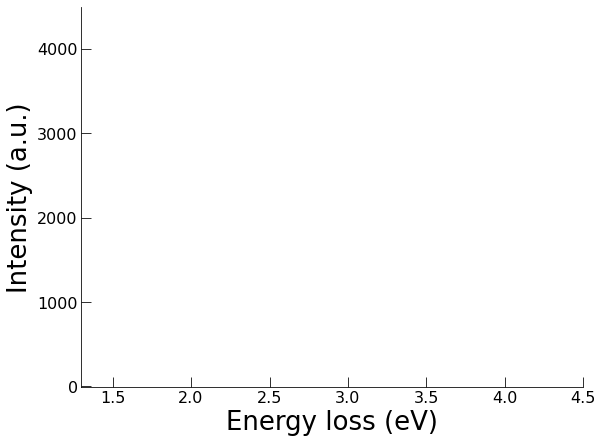

In [65]:
import matplotlib
nrows, ncols = 3,2
gs = matplotlib.gridspec.GridSpec(nrows,ncols)
plt.figure(figsize=(ncols*5,nrows*4))
meanmean=[]

from matplotlib import rc
from matplotlib import cm
cm_subsection = np.linspace(0,1,14) 
colors = [cm.viridis(x) for x in cm_subsection]
hfont = rc('font',**{'family':'sans-serif','sans-serif':['Sans Serif']})

nrows, ncols = 1,1
gs = matplotlib.gridspec.GridSpec(nrows,ncols)
plt.figure(figsize=(ncols*9,nrows*7))

cm_subsection = np.linspace(0,1,24) 
colors = [cm.viridis(x) for x in cm_subsection]

hfont = rc('font',**{'family':'sans-serif','sans-serif':['Sans Serif']})
amp = 2700
pars = [amp, 1.59, 1.257]
pars_high = [amp, 1.59, (1.26 + 0.3)]
pars_low = [amp, 1.59, (1.26 - 0.74)]
          
for i in range(1):
    ax = plt.subplot(gs[i])
    ax.set_xlim([1.3,4.5])
    ax.set_ylim([-1e1,4.5e3])
    ax.set_ylabel('Intensity (a.u.)', fontsize=26)
    ax.set_xlabel('Energy loss (eV)', fontsize=26)
    
    ax.tick_params(which='major',direction='in',length=10, labelsize=16)
    ax.tick_params(which='minor',length=10)
    ax.set_xticks([1.5, 2, 2.5, 3, 3.5 , 4, 4.5])
    
    p1=ax.plot(np.linspace(-.3, 12, nbins), mean_rep['spectrum14'], 'k--',ls="dashdot",lw=2)

    
    p2=ax.plot(np.linspace(-.3, 12, nbins), mean_rep['match14_median'], color=rescolors[1],ls="dashed",lw=2)
    ax.fill_between(np.linspace(-.3, 12, nbins), mean_rep['match14_low'], mean_rep['match14_high'], \
                    color=rescolors[1], alpha=.2)
    p2b=ax.fill(np.NaN,np.NaN,color=rescolors[1],alpha=0.2)
    
    p3 = ax.plot(np.linspace(-.3, 12, nbins), mean_rep['dif14_median'], 'k-',color=rescolors[0],lw=2)
    ax.fill_between(np.linspace(-.3, 12, nbins), mean_rep['dif14_low'], mean_rep['dif14_high'], color=rescolors[0], alpha=.2)
    p3b=ax.fill(np.NaN,np.NaN,color=rescolors[0],alpha=0.2)
    ax.set_yticks([])

    ax.legend([(p1[0]),(p3[0],p3b[0]),(p2[0],p2b[0])],['sp14 (orig)','sp14 (subtr)',"ZLP"],loc='upper right', fontsize = 19)
    
    axins = ax.inset_axes([0.55, 0.10, 0.43, 0.40])
    
    axins.get_xaxis().set_visible(True)
    axins.get_yaxis().set_visible(True)
    axins.spines['right'].set_visible(True)
    axins.spines['top'].set_visible(True)
    axins.set_xticks([1, 2, 3, 4])
    axins.set_xlim([1,3.02])
    axins.set_ylim([-1e3, 5e3])
    
    p1=axins.plot(np.linspace(-.3, 12, nbins), mean_rep['dif14_median'], 'k-', alpha=.8, label='sp14 (subtr)',color=rescolors[0])
    axins.fill_between(np.linspace(-.3, 12, nbins), mean_rep['dif14_low'], \
                       mean_rep['dif14_high'], color=rescolors[0],alpha=0.2,lw=2)
    p1b=axins.fill(np.NaN,np.NaN,color=rescolors[0],alpha=0.2)
    
    
    x = np.linspace(1.5, 2.7, 100)
    p2=axins.plot(x, bandgap(x, *pars), label='Model fit',color=rescolors[2],lw=2,ls="dashed")
    axins.fill_between(x, bandgap(x, *pars_low), \
                       bandgap(x, *pars_high), color=rescolors[2], alpha=.2)
    p2b=axins.fill(np.NaN,np.NaN,color=rescolors[2],alpha=0.2)
    axins.tick_params(which='both',direction='in', labelsize=12,right=True)
    axins.tick_params(which='major',length=10)
    axins.tick_params(which='minor',length=10)
    axins.set_yticks([])
    axins.legend([(p1[0],p1b[0]),(p2[0],p2b[0])],['sp14 (subtr)','Model fit'],loc='upper left', fontsize=15)
    

    
    

plt.tight_layout()
plt.savefig('SubtractedEELS_plot_sp14.pdf')
print("Saved fig = SubtractedEELS_plot_sp14.pdf")


## File with average prediction data


For each replica $k$, the NN gives a prediction on the ZLP: $ZLP_k$. The substracted spectrum at each iteration is then $Substraction_k = original\_spectrum - ZLP_k$.  

In [851]:
total_replicas = r180

mean_pred, var_pred, count_replicas_pred = \
    binned_statistics(total_replicas['x14'], total_replicas['prediction y'], nbins)[0:3]

pred_high, pred_low = binned_statistics(total_replicas['x14'], total_replicas['prediction y'], nbins)[3:5]

In [857]:
mean_rep = pd.DataFrame()
total_bins = len(original['x14'])
print(total_bins)
wl = 6

mean_rep['pred'] = mean_pred
mean_rep['pred_high'], mean_rep['pred_low'] = pred_high, pred_low

total_replicas['dif14'][total_replicas['dif14'] < 0] = 0

for i in ([14]):
    mean_dif, var_dif =  binned_statistics(total_replicas['x%(i)s'%{"i":i}], 
                                           total_replicas['dif%(i)s'%{"i":i}], total_bins)[0:2]
    dif_high, dif_low =  binned_statistics(total_replicas['x%(i)s'%{"i":i}], 
                                           total_replicas['dif%(i)s'%{"i":i}], total_bins)[3:5]
    dif_median = get_median(total_replicas['x%(i)s'%{"i":i}], 
                                           total_replicas['dif%(i)s'%{"i":i}], total_bins)
    
    mean_rep['dif%(i)s'%{"i":i}],mean_rep['sigma_dif%(i)s'%{"i":i}] = smooth(mean_dif, wl), smooth(var_dif, wl)
    mean_rep['dif%(i)s_high'%{"i":i}],mean_rep['dif%(i)s_low'%{"i":i}] = \
                                            smooth(dif_high, wl),smooth(dif_low, wl)
    mean_rep['dif%(i)s_median'%{"i":i}] = smooth(dif_median, wl)
    
    mean_match, var_match = binned_statistics(total_replicas['x%(i)s'%{"i":i}], 
                                           total_replicas['match%(i)s'%{"i":i}], total_bins)[0:2]
    match_high, match_low =  binned_statistics(total_replicas['x%(i)s'%{"i":i}], 
                                           total_replicas['match%(i)s'%{"i":i}], total_bins)[3:5]
    
    match_median = get_median(total_replicas['x%(i)s'%{"i":i}], 
                                           total_replicas['match%(i)s'%{"i":i}], total_bins)
    
    mean_rep['match%(i)s'%{"i":i}], mean_rep['sigma_match%(i)s'%{"i":i}] = \
                                            smooth(mean_match, wl), smooth(var_match, wl)
    mean_rep['match%(i)s_high'%{"i":i}], mean_rep['match%(i)s_low'%{"i":i}] = \
                                            smooth(match_high, wl), smooth(match_low, wl)
    mean_rep['match%(i)s_median'%{"i":i}] = smooth(match_median, wl)
    
    mean_rep['spectrum%(i)s'%{"i":i}] = smooth(original['y%(i)s'%{"i":i}], wl)

493


<ipython-input-857-f209bcbb7fc5>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_replicas['dif14'][total_replicas['dif14'] < 0] = 0


In [855]:
mean_rep.to_csv('paper_EELSML/slides/data/Subtracted_spectrum.csv')

<ipython-input-746-28fc0397b126>:5: RuntimeWarning: invalid value encountered in power
  return amp * (x - BG)**(b)
<ipython-input-746-28fc0397b126>:5: RuntimeWarning: invalid value encountered in power
  return amp * (x - BG)**(b)


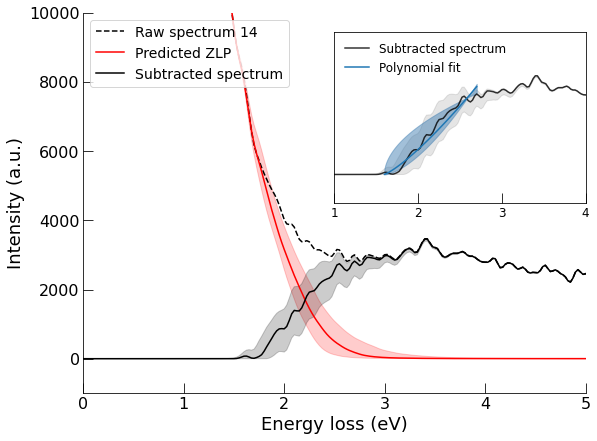

In [856]:
import matplotlib
from matplotlib import rc

mean_rep = pd.read_csv('paper_EELSML/slides/data/Subtracted_spectrum.csv')

nrows, ncols = 1,1
gs = matplotlib.gridspec.GridSpec(nrows,ncols)
plt.figure(figsize=(ncols*9,nrows*7))

cm_subsection = np.linspace(0,1,24) 
colors = [cm.viridis(x) for x in cm_subsection]

hfont = rc('font',**{'family':'sans-serif','sans-serif':['Sans Serif']})
amp = 2700
pars = [amp, 1.59, 1.257]
pars_high = [amp, 1.59, (1.26 + 0.3)]
pars_low = [amp, 1.59, (1.26 - 0.74)]
          
for i in range(1):
    ax = plt.subplot(gs[i])
    ax.set_xlim([1,5])
    ax.set_ylim([-1e3,1e4])
    ax.set_ylabel('Intensity (a.u.)', fontsize=18)
    ax.set_xlabel('Energy loss (eV)', fontsize=18)
    
    ax.tick_params(which='major',direction='in',length=10, labelsize=16)
    ax.tick_params(which='minor',length=10)
    ax.set_xticks([0, 1, 2, 3, 4, 5])
    
    ax.plot(np.linspace(-.3, 12, nbins), mean_rep['spectrum14'], 'k--', label='Raw spectrum 14')
    ax.plot(np.linspace(-.3, 12, nbins), mean_rep['match14_median'], color='red', label='Predicted ZLP')
    ax.fill_between(np.linspace(-.3, 12, nbins), mean_rep['match14_low'], mean_rep['match14_high'], \
                    color='red', alpha=.2)
    
    ax.plot(np.linspace(-.3, 12, nbins), mean_rep['dif14_median'], 'k-', label='Subtracted spectrum')
    ax.fill_between(np.linspace(-.3, 12, nbins), mean_rep['dif14_low'], mean_rep['dif14_high'], color='black', alpha=.2)
    

    ax.legend(loc='upper left', fontsize = 14)
    
    axins = ax.inset_axes([0.50, 0.5, 0.5, 0.45])
    
    axins.get_xaxis().set_visible(True)
    axins.get_yaxis().set_visible(True)
    axins.spines['right'].set_visible(True)
    axins.spines['top'].set_visible(True)
    axins.set_xticks([1, 2, 3, 4])
    axins.set_xlim([1,4])
    axins.set_ylim([-1e3, 5e3])
    
    axins.plot(np.linspace(-.3, 12, nbins), mean_rep['dif14_median'], 'k-', alpha=.8, label='Subtracted spectrum')
    axins.fill_between(np.linspace(-.3, 12, nbins), mean_rep['dif14_low'], \
                       mean_rep['dif14_high'], color='black', alpha=.1)
    
   
    
    x = np.linspace(1.5, 2.7, 100)
    axins.plot(x, bandgap(x, *pars), label='Polynomial fit')
    axins.fill_between(x, bandgap(x, *pars_low), \
                       bandgap(x, *pars_high), color='steelblue', alpha=.5)
    axins.tick_params(which='both',direction='in', labelsize=12,right=True)
    axins.tick_params(which='major',length=10)
    axins.tick_params(which='minor',length=10)
    axins.set_yticks([])
    axins.legend(loc='upper left', fontsize=12, frameon=False)

    
    
   

## Ratio Sample/sigma(ZLP)

/Users/laurienroest/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/laurienroest/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


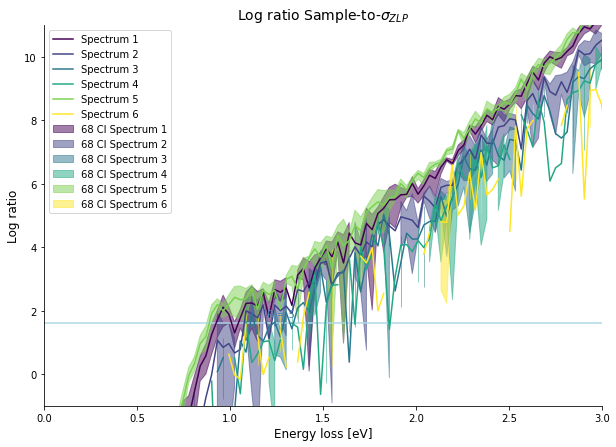

In [172]:
from matplotlib import cm
cm_subsection = np.linspace(0,1,6) 
colors = [cm.viridis(x) for x in cm_subsection ]
plt.figure(figsize=(10,7))
plt.axhline(y= np.log(5), color='lightblue')
plt.text(1.2, np.log(5) + 0.2, s='R = 5', color='steelblue')


for i, color in enumerate(colors):
    function1 = mean_replicas['ratio%(k)s' %{"k": i+1}]
    function2 = mean_replicas['ratio%(k)s_high' %{"k": i+1}]
    function3 = mean_replicas['ratio%(k)s_low' %{"k": i+1}]
    plt.plot(np.linspace(-.3, 12, nbins), np.log(function1),  color = color, label='Spectrum %(k)s' %{"k": i+1})
    plt.fill_between(np.linspace(-.3, 12, nbins), np.log(function2), np.log(function3),  color = color, alpha=.5, label='68 CI Spectrum %(k)s' %{"k": i+1})
    #plt.plot(np.linspace(-.3, 3, nbins), np.log(function3),  color = color, alpha=.5,label='Spectrum low %(k)s' %{"k": i+1})
plt.legend()
plt.xlabel('Energy loss [eV]', fontsize=12)
plt.xlim([0, 3])
plt.ylim(-1, 11)

plt.ylabel('Log ratio', fontsize=12)
plt.title('Log ratio Sample-to-$\sigma_{ZLP}$', fontsize=14)
plt.savefig('Data/Results/Log-ratio-sigma.png')
plt.show()
    

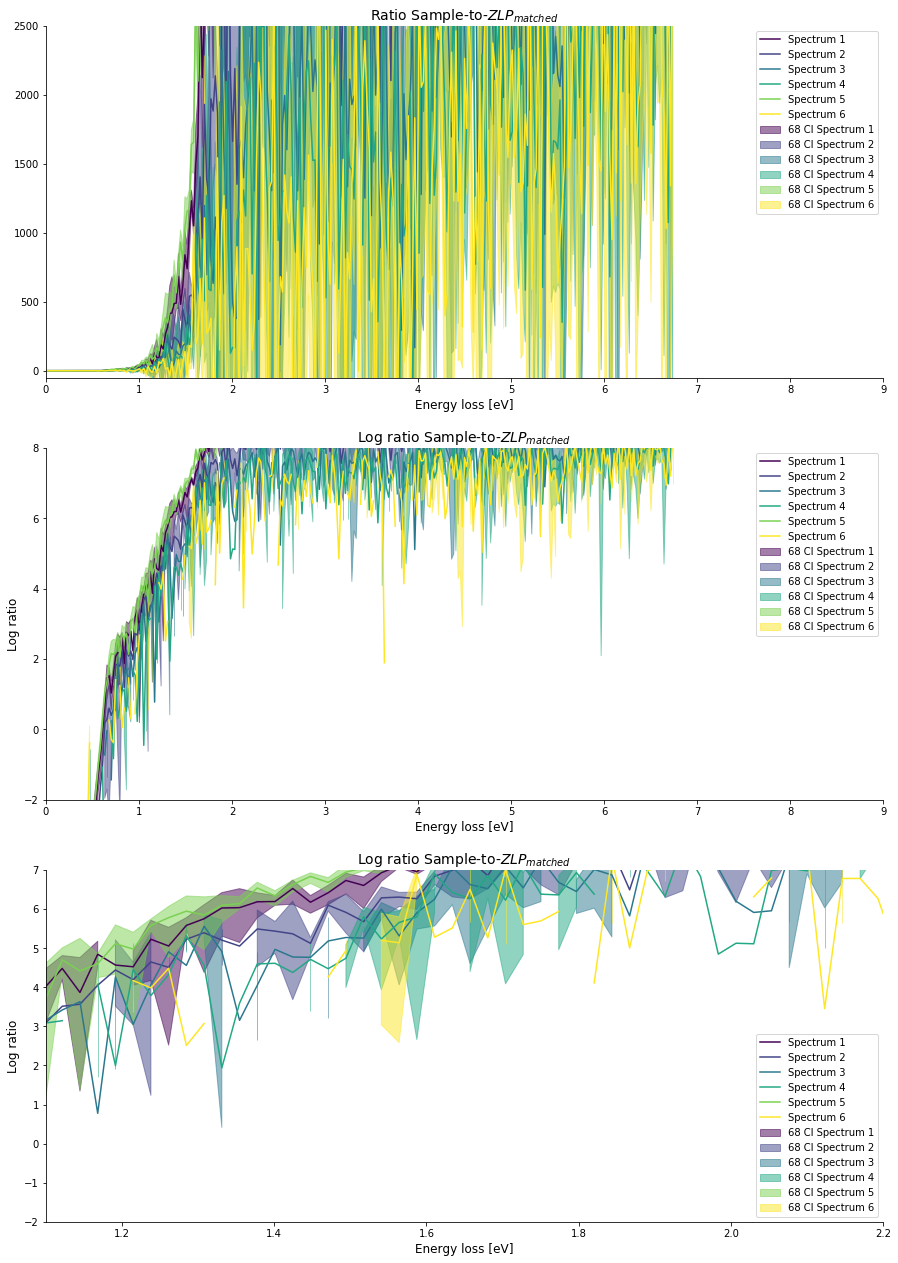

In [173]:
dE1 = max(training_data['x'][(training_data['x']< 1)])
dE2 = min(training_data['x'][(training_data['x']> 1)])


plt.figure(figsize=(15,22))
plt.subplot(311)
##plt.text(1.2, (5) + 0.2, s='R = 5', color='steelblue')
for i, color in enumerate(colors):
    function1 = mean_replicas['zatio%(k)s' %{"k": i+1}]
    function2 = mean_replicas['zatio%(k)s_high' %{"k": i+1}]
    function3 = mean_replicas['zatio%(k)s_low' %{"k": i+1}]
    plt.plot(np.linspace(-.3, 8.9975, nbins), (function1),  color = color, label='Spectrum %(k)s' %{"k": i+1})
    plt.fill_between(np.linspace(-.3, 8.9975, nbins), (function2), (function3),  color = color, alpha=.5, label='68 CI Spectrum %(k)s' %{"k": i+1})
    #plt.plot(np.linspace(-.3, 3, nbins), np.log(function3),  color = color, alpha=.5,label='Spectrum low %(k)s' %{"k": i+1})
plt.legend()
plt.xlabel('Energy loss [eV]', fontsize=12)
plt.xlim([0, 8.9975])
plt.ylim(-50, 2500)
#plt.ylabel('Ratio', fontsize=12)
plt.title('Ratio Sample-to-$ZLP_{matched}$', fontsize=14)

plt.subplot(312)
#plt.axhline(y= np.log(5), color='lightblue')
#plt.text(1.2, np.log(5) + 0.2, s='R = 5', color='steelblue')
for i, color in enumerate(colors):
    function1 = mean_replicas['zatio%(k)s' %{"k": i+1}]
    function2 = mean_replicas['zatio%(k)s_high' %{"k": i+1}]
    function3 = mean_replicas['zatio%(k)s_low' %{"k": i+1}]
    plt.plot(np.linspace(-.3, 8.9975, nbins), np.log(function1),  color = color, label='Spectrum %(k)s' %{"k": i+1})
    plt.fill_between(np.linspace(-.3, 8.9975, nbins), np.log(function2), np.log(function3),  color = color, alpha=.5, label='68 CI Spectrum %(k)s' %{"k": i+1})
    #plt.plot(np.linspace(-.3, 3, nbins), np.log(function3),  color = color, alpha=.5,label='Spectrum low %(k)s' %{"k": i+1})
plt.legend()
plt.xlabel('Energy loss [eV]', fontsize=12)
plt.xlim([0, 8.9975])
plt.ylim(-2, 8)

plt.ylabel('Log ratio', fontsize=12)
plt.title('Log ratio Sample-to-$ZLP_{matched}$', fontsize=14)

plt.subplot(313)
#plt.axhline(y= np.log(5), color='lightblue')
#plt.text(1.2, np.log(5) + 0.2, s='R = 5', color='steelblue')
for i, color in enumerate(colors):
    function1 = mean_replicas['zatio%(k)s' %{"k": i+1}]
    function2 = mean_replicas['zatio%(k)s_high' %{"k": i+1}]
    function3 = mean_replicas['zatio%(k)s_low' %{"k": i+1}]
    plt.plot(np.linspace(-.3, 8.9975, nbins), np.log(function1),  color = color, label='Spectrum %(k)s' %{"k": i+1})
    plt.fill_between(np.linspace(-.3, 8.9975, nbins), np.log(function2), np.log(function3),  color = color, alpha=.5, label='68 CI Spectrum %(k)s' %{"k": i+1})
    #plt.plot(np.linspace(-.3, 3, nbins), np.log(function3),  color = color, alpha=.5,label='Spectrum low %(k)s' %{"k": i+1})
plt.legend()
plt.xlabel('Energy loss [eV]', fontsize=12)
plt.xlim([1.1,2.2])
plt.ylim(-2, 7)
plt.ylabel('Log ratio', fontsize=12)
plt.title('Log ratio Sample-to-$ZLP_{matched}$', fontsize=14)

plt.savefig('Data/Results/Log-ratio-ZLP.png')
plt.show()


    

### Average over all replicas

In order to obtain predictions on the substracted spectra, one has to average over all the replicas. This yields the mean and variance of the substractions, plotted in green below. 

Predicted ZLP mean = $1 / N_{rep} \cdot \sum_k ZLP_k $ \
\
Mean substraction = $1 / N_{rep} \cdot \sum_k (spectrum - ZLP_k )$ 


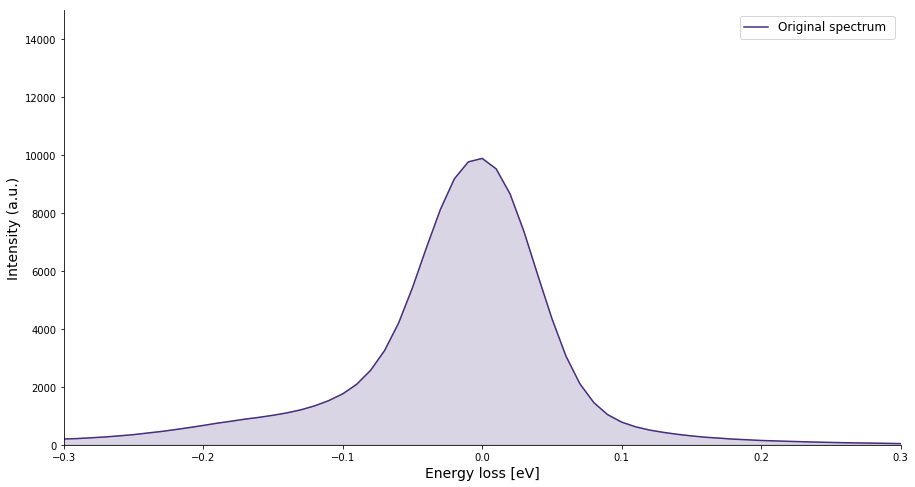

In [174]:
from matplotlib import cm
cm_subsection = np.linspace(0,1,9) 
colors = [ cm.viridis(x) for x in cm_subsection ]

plt.figure(figsize=(15,8))
plt.plot(original['x1'], original['y1']/1000, color=colors[1],label='Original spectrum ')
#plt.plot(mean_replicas['x'], mean_replicas['pred']/1000, color=colors[6],label='Median Predicted ZLP')
#plt.axvline(x=dE1, label='dE1', linestyle='--', color='darkgray')
#plt.axvline(x=dE0, label='dE0', linestyle='--', color='lightgray')
#plt.plot(np.linspace(-.3, 8.9975, nbins), mean_replicas['match1']/1000,  linewidth=2, label='Matched ZLP', color=colors[1])
#plt.plot(mean_replicas['x'], mean_replicas['dif1']/1000, color=colors[5],label='Subtraction' % {"i": i})
plt.fill_between(original['x1'], original['y1']/1000, 0, color=colors[1], alpha=.2)

plt.legend(fontsize='large')
plt.xlim([-.3,.3])
plt.ylabel('Intensity (a.u.)', fontsize=14)
plt.xlabel('Energy loss [eV]', fontsize=14)
plt.ylim([0, 15e6/1000])
plt.savefig('Data/Results/Subtracted_spectra(rescale).png')
plt.show()

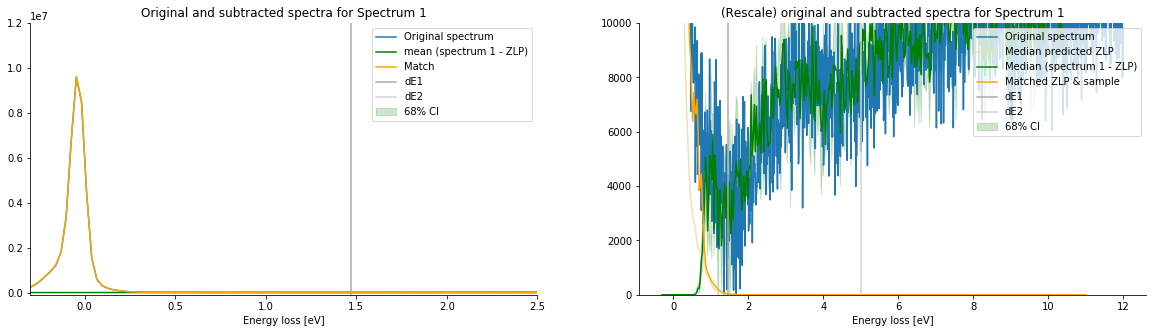

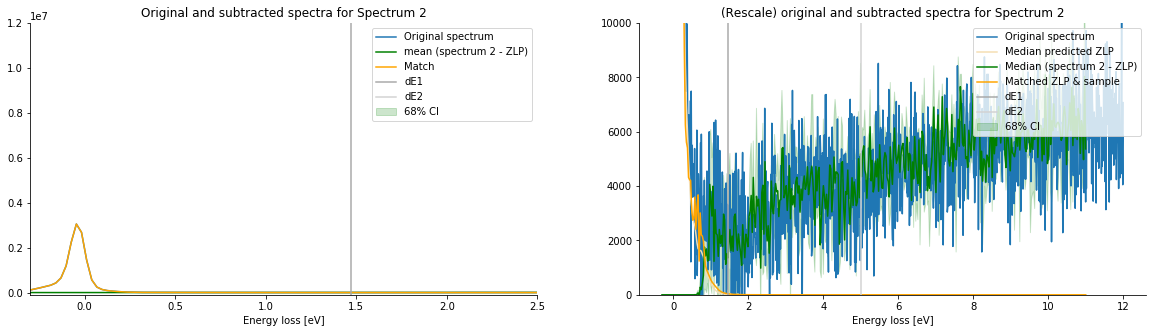

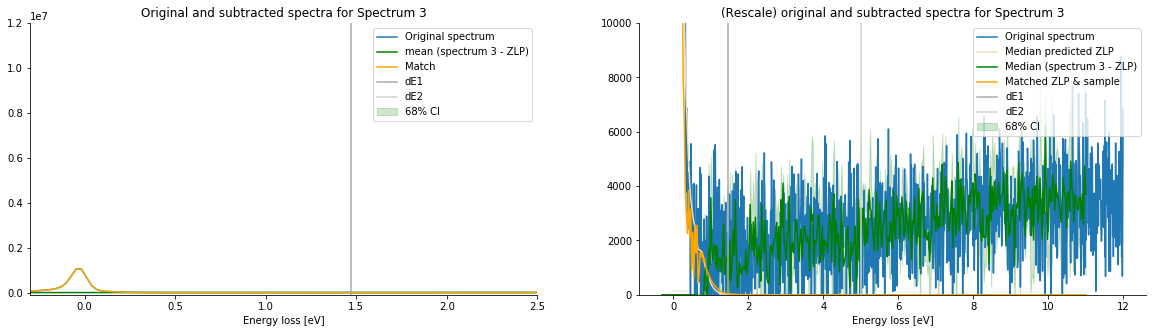

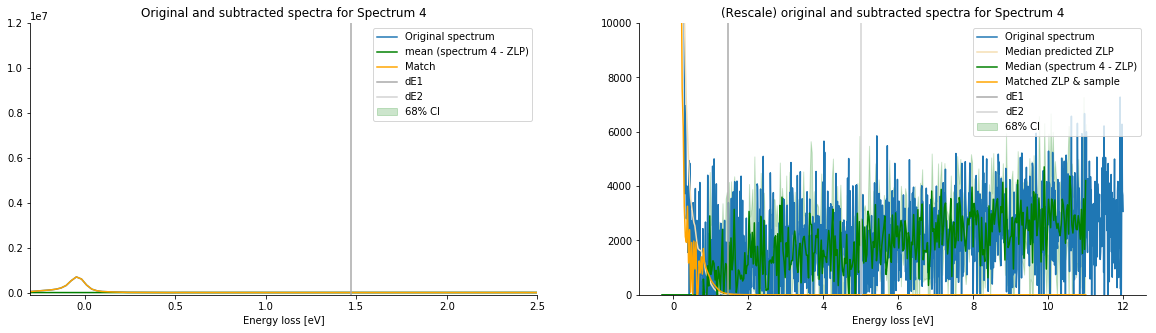

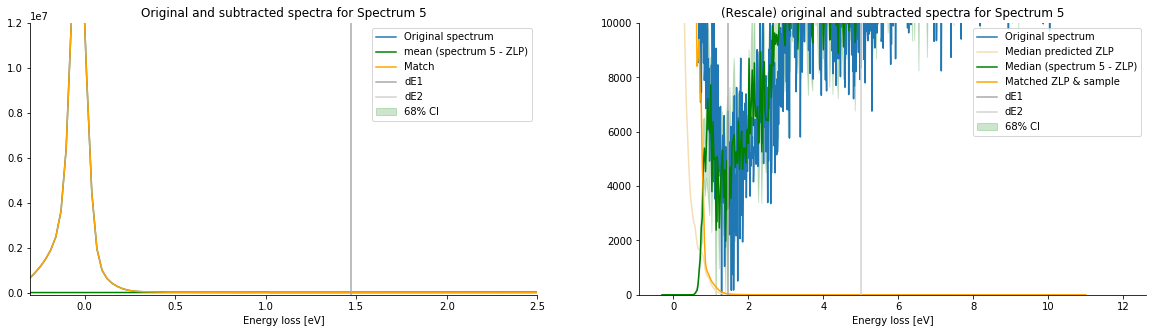

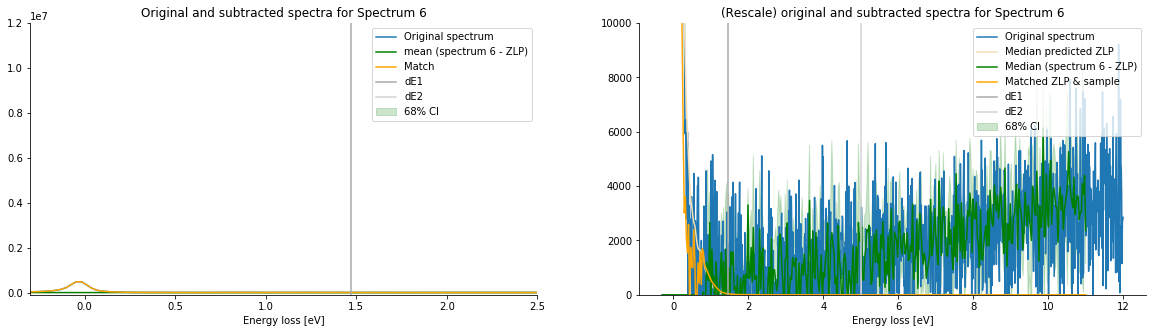

In [175]:
dE1 = max(training_data['x'][(training_data['x']< 2)])
dE2 = min(training_data['x'][(training_data['x']> 2)])
nbins = 400


for i in ('1', '2', '3', '4', '5', '6'):
    
    plt.figure(figsize=(20,5))
    
    plt.subplot(121)
    plt.plot(np.linspace(-.3, 11, nbins), mean_replicas['y'+i], label='Original spectrum ')
   # plt.plot(mean_replicas['x'], mean_replicas['pred'], label='Mean predicted ZLP')
    plt.plot(np.linspace(-.3, 11, nbins), mean_replicas['dif'+i], color='green',label='mean (spectrum %(i)s - ZLP)' % {"i": i})
    plt.plot(np.linspace(-.3, 11, nbins), mean_replicas['match'+i], label='Match', color='orange')
    plt.fill_between(mean_replicas['x'], mean_replicas['high'+i], \
                     mean_replicas['low'+i], color='green',alpha=.2, label='68% CI')
    plt.title("Original and subtracted spectra for Spectrum %(i)s" %{"i": i})
    plt.axvline(x=dE1, label='dE1', linestyle='-', color='darkgray')
    plt.axvline(x=dE2, label='dE2', linestyle='-', color='lightgray')
    plt.xlim([-.3,2.5])
    plt.ylim([-1e5, 1.2e7])
    plt.xlabel('Energy loss [eV]')
    plt.legend(loc='upper right')
    
    
    plt.subplot(122)
    plt.plot(original['x1'], original['y'+i], label='Original spectrum ')
    plt.plot(mean_replicas['x'], mean_replicas['median'], color='wheat',label='Median predicted ZLP')
    plt.plot(mean_replicas['x'], mean_replicas['dif'+i], color='green',label='Median (spectrum %(i)s - ZLP)' % {"i": i})
    plt.plot(mean_replicas['x'], mean_replicas['match'+i], label='Matched ZLP & sample', color='orange')
    plt.fill_between(mean_replicas['x'], mean_replicas['high'+i], \
                     mean_replicas['low'+i], color='green',alpha=.2, label='68% CI')
    plt.axvline(x=dE1, label='dE1', linestyle='-', color='darkgray')
    plt.axvline(x=dE2, label='dE2', linestyle='-', color='lightgray')
    plt.title("(Rescale) original and subtracted spectra for Spectrum %(i)s" %{"i": i})
    #plt.xlim([0,2.5])
    plt.ylim([0, 1e4])
    plt.xlabel('Energy loss [eV]')
    plt.legend(loc='upper right')
    plt.savefig('Data/Results/Subtracted_spectra_%(i)s.png' % {"i": i})
    plt.show()

## Report

Create a standardized report file with the main outcomes

In [31]:
import sys
import base64
from prettytable import PrettyTable
pt = PrettyTable

d_string = '17.06.2020'


reportname = r'Reports/%(date)s_%(i)s_chi2=%(chi)s.html' % {"date": d_string, "i": round_no, "chi": selection_min }
sys.stdout = open(reportname,'w')

print((d_string )+ 'round' + str( round_no ) + '<br />')
print('Subtraction of original spectrum 1 <br /><br />')
print('<br />')
print('<br /> dEO:', dE0)
print('<br /> dE1:', dE1)
print('<br /> dE2:', dE2)
print('<br />')
print('<br />')
list1 = ['Training window:', 'Pseudo data added in range:']
list2 = [str([-.3, max(training_data['x'][(training_data['x']< 1)])]) +' eV', \
         str([min(training_data['x'][(training_data['x']> 1)]), max(training_data['x'][(training_data['x']>1)])]) + 'eV']
for x in range(0,2):
    print('%(s1)s %(s2)s <br />' % {"s1": list1[x], "s2": list2[x]}) 


list1 = ['Total no. of replicas:', 'Criterium Chi2:', 'Used no. of replicas:']
list2 = [len(all_files), selection_min, len(use_files)]

for x in range(0,3):
    print('%(s1)s %(s2)s <br />' % {"s1": list1[x], "s2": list2[x]}) 

In [32]:
plot1 = r'Data/Results/Example_individual_replicas.png'
plot2 = r'Data/Results/Example_individual_replicas(rescale).png'

plot3 = r'Data/Results/histogram.png'
plot4 = r'Data/Results/Subtracted_spectra.png'
plot5 = r'Data/Results/Subtracted_spectra(rescale).png'

plot6 = r'Data/Results/Ratio.png'
plot7 = r'Data/Results/Logratio.png'

plot8 = r'Data/Results/Log-ratio-sigma.png'
plot9 = r'Data/Results/Log-ratio-ZLP.png'

data_uri3 = base64.b64encode(open(plot3, 'rb').read()).decode('utf-8')
data_uri4 = base64.b64encode(open(plot4, 'rb').read()).decode('utf-8')
data_uri5 = base64.b64encode(open(plot5, 'rb').read()).decode('utf-8')
data_uri6 = base64.b64encode(open(plot6, 'rb').read()).decode('utf-8')
data_uri7 = base64.b64encode(open(plot7, 'rb').read()).decode('utf-8')
data_uri8 = base64.b64encode(open(plot8, 'rb').read()).decode('utf-8')
data_uri9 = base64.b64encode(open(plot9, 'rb').read()).decode('utf-8')

img_tag3 = '<img src="data:image/png;base64,{0}">'.format(data_uri3)
img_tag4 = '<img src="data:image/png;base64,{0}">'.format(data_uri4)
img_tag5 = '<img src="data:image/png;base64,{0}">'.format(data_uri5)
img_tag6 = '<img src="data:image/png;base64,{0}">'.format(data_uri6)
img_tag7 = '<img src="data:image/png;base64,{0}">'.format(data_uri7)
img_tag8 = '<img src="data:image/png;base64,{0}">'.format(data_uri8)
img_tag9 = '<img src="data:image/png;base64,{0}">'.format(data_uri9)

print(img_tag3)
print(img_tag6)
print(img_tag7)

for i in range(1,10):
    plot1 = r'Data/Results/Subtracted_spectra_%(i)s.png' % {"i": i}
    uri1 = base64.b64encode(open(plot1, 'rb').read()).decode('utf-8')
    tag1 = '<img src="data:image/png;base64,{0}">'.format(uri1)
    print(tag1)
    
print(img_tag8)
print(img_tag9)

